<a href="https://colab.research.google.com/github/nerbivol/Methods-and-systems-of-artificial-intelligence/blob/main/cascade_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 
import numpy as np 
import glob
import dlib
import imutils
import random

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

%matplotlib inline 
from matplotlib import pyplot as plt

In [ ]:
path = "/content/drive/MyDrive/Colab Data/face/Robert/*"
images = [cv2.imread(file) for file in glob.glob(path)]

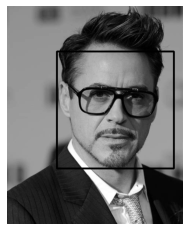

In [ ]:
img = images[34].copy()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
detected_faces = face_cascade.detectMultiScale(img)
for (column, row, width, height) in detected_faces:
    cv2.rectangle(img,(column, row),(column + width, row + height),(0, 255, 0),4)    
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()

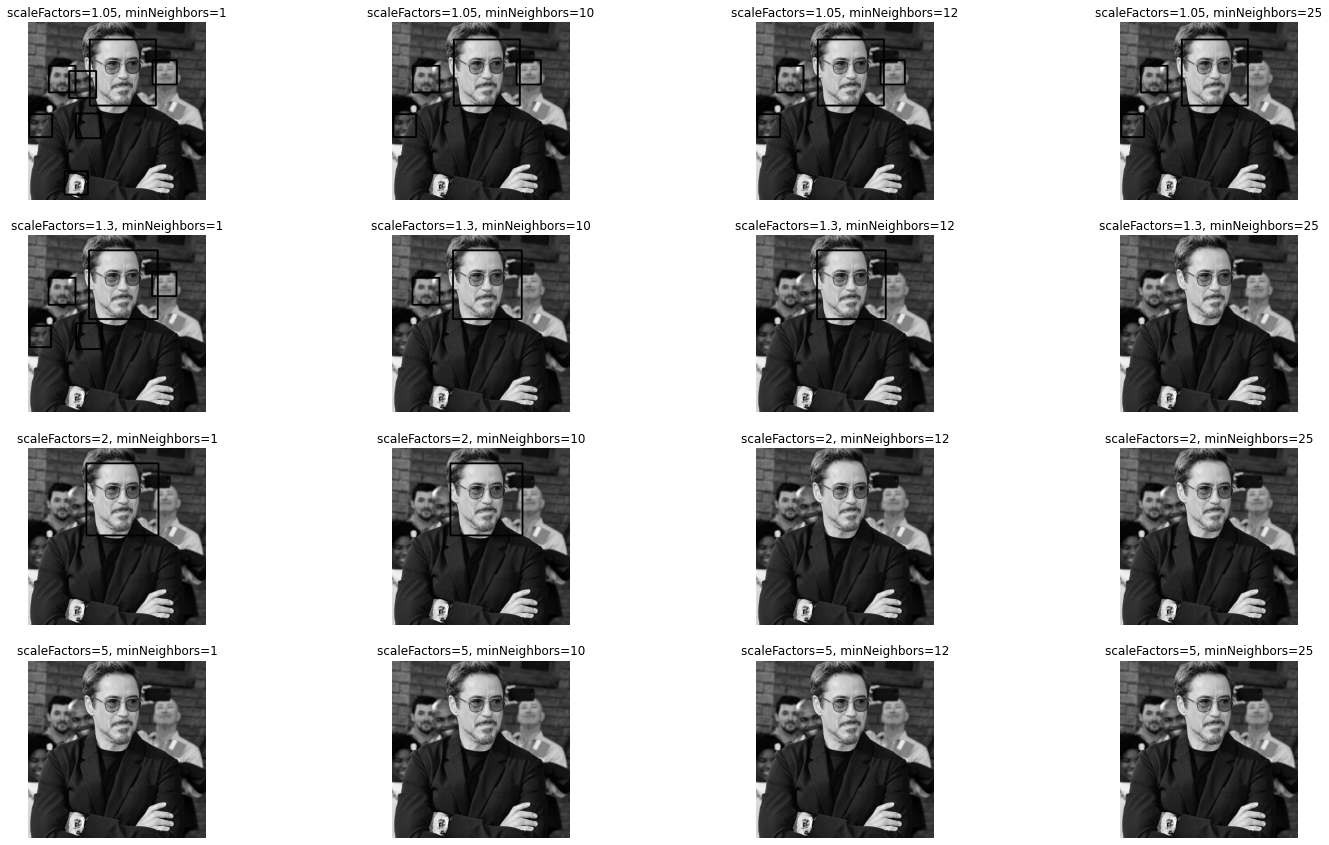

In [ ]:
scaleFactors = [1.05, 1.3, 2, 5]
minNeighbors = [1, 10, 12, 25]

fig, ax = plt.subplots(4, 4, figsize=(25, 15))

for i, scaleFactor in enumerate(scaleFactors):
  for j, minNeighbor in enumerate(minNeighbors):
    img = images[1].copy()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    detected_faces = face_cascade.detectMultiScale(img, scaleFactor=scaleFactor, minNeighbors=minNeighbor)
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(img,(column, row),(column + width, row + height),(0, 255, 0),4) 
    
    ax[i,j].imshow(img, cmap='gray')
    ax[i,j].set(title = f'scaleFactors={scaleFactor}, minNeighbors={minNeighbor}')
    ax[i,j].axis("off")

При дослідженні параметрів minNeighbors та scaleFactor бачимо, що scaleFactor змінює розмір рамки навколо обличчя,  minNeighbors контролює скільки облич можна визначити для одного зображення. Найкращий варіант при параметрах scaleFactor = 1.3 і minNeighbors=12.


Також перевіримо, як при даних параметрах працює алгоритм для інших зображень

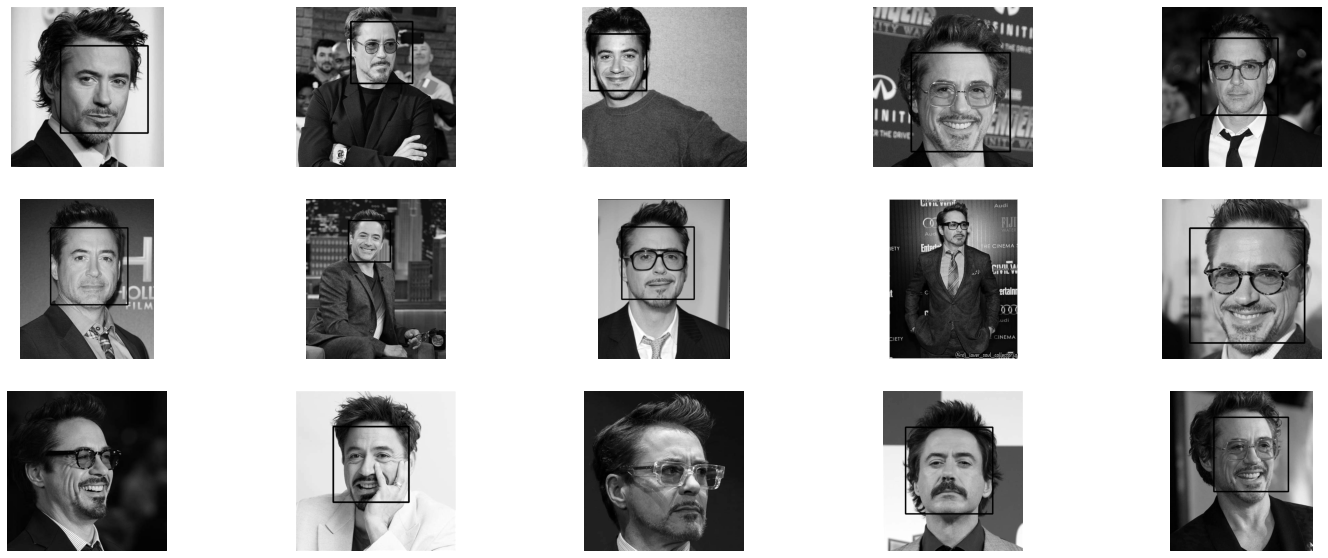

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(25, 10))

for i, img in enumerate(images[:15]):
  img = img.copy()
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  detected_faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=12)
  for (x, y, w, h) in detected_faces:
      cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 0),4)    
  plt.subplot(3, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.axis("off")

Тож бачимо, що алгоритм вдало визначає лице на зображеннях. Лише на зображення де Роберт повернув голову виникають помилки. Але якщо параметри зменшити, то алгоритм почне визначати обличчя там де їх немає.

### Перевіримо як працює HOG детектор:

In [ ]:
def convert_and_trim_bb(image, rect):
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()

	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
 
	w = endX - startX
	h = endY - startY
	return (startX, startY, w, h)

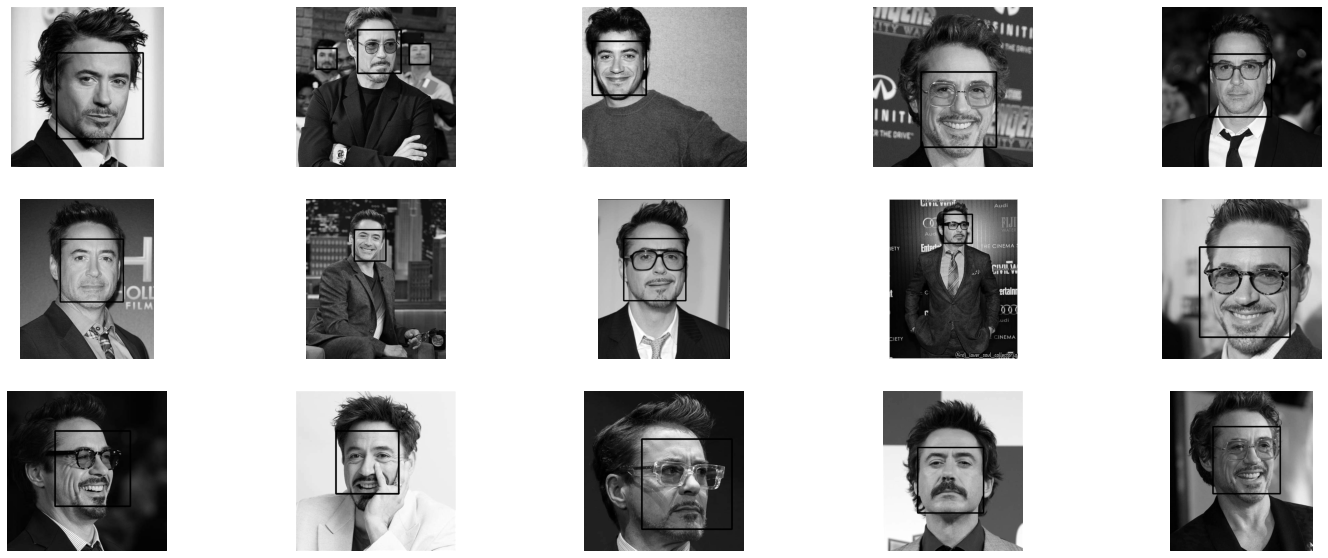

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(25, 10))

for i, img in enumerate(images[:15]):
  img = img.copy()
  hogFaceDetector = dlib.get_frontal_face_detector()
  detected_faces = hogFaceDetector(img, 1)
  boxes = [convert_and_trim_bb(img, r) for r in detected_faces]
  
  for (x, y, w, h) in boxes:
      cv2.rectangle(img,(x, y),(x + w, y + h),(0, 255, 0),4)
      
  plt.subplot(3, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.axis("off")

Метод HOG виділяє обличчя також добре, проте також і інші лиця на зображеннях, які нам не потрібні. Також звернемо увагу на розмір рамки навколо обличчя. Вона є меншою та не повністю покриває лице, що негативно відображатиметься при навчання моделі.

Підготуємо дані для навчання

In [ ]:
X_true = []
directory = '/content/drive/MyDrive/Colab Data/cnn/Robert/'

for i, img in enumerate(images):
  img = img.copy()
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  detected_faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=12)
  for (column, row, width, height) in detected_faces:
    face = cv2.resize(img[row:row + height, column:column + width], (100, 100))
    X_true.append(face)
    path = f"{directory}{i}.jpg"
    cv2.imwrite(path, face)

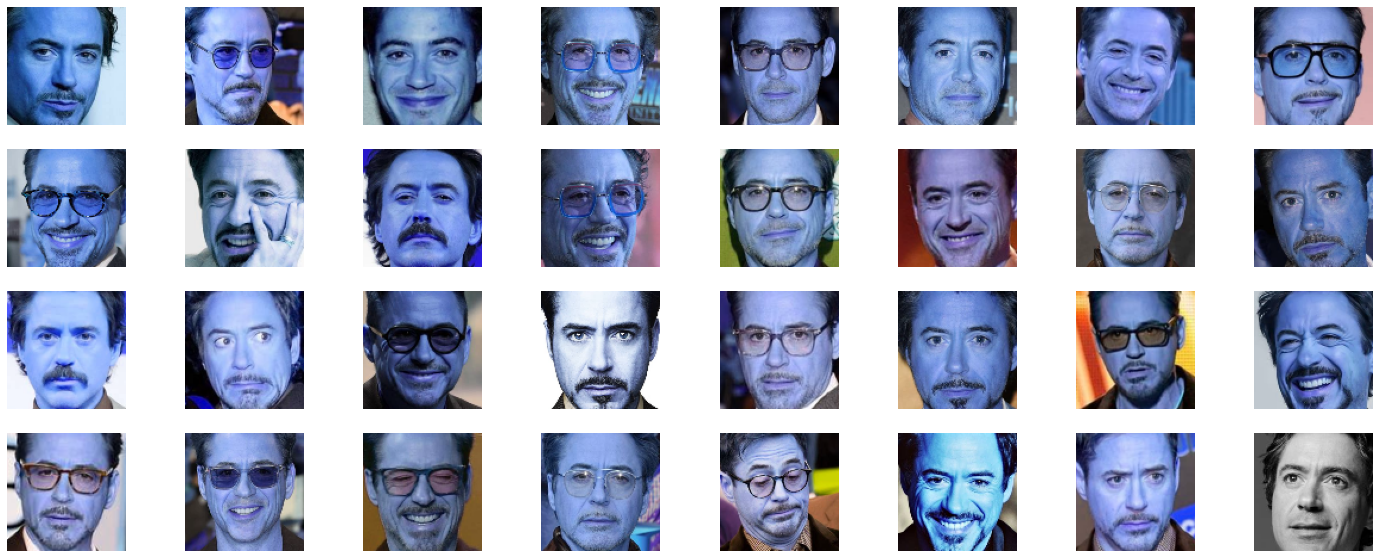

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(25, 10))

for i, face in enumerate(X_true[:32]):
  plt.subplot(4, 8, i+1)
  plt.imshow(face, cmap='gray')
  plt.axis("off")

In [ ]:
path = "/content/drive/MyDrive/Colab Data/face/NRobert/*"
not_robert = [cv2.imread(file) for file in glob.glob(path)]

In [ ]:
X_false = []
directory = '/content/drive/MyDrive/Colab Data/cnn/NRobert/'

for i, img in enumerate(not_robert):
  img = imutils.resize(img, width=500)
  img = img.copy()
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  detected_faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
  for (column, row, width, height) in detected_faces:
    face = cv2.resize(img[row:row + height, column:column + width], (100, 100))
    X_false.append(face)
    path = f"{directory}{i}.jpg"
    cv2.imwrite(path, face)

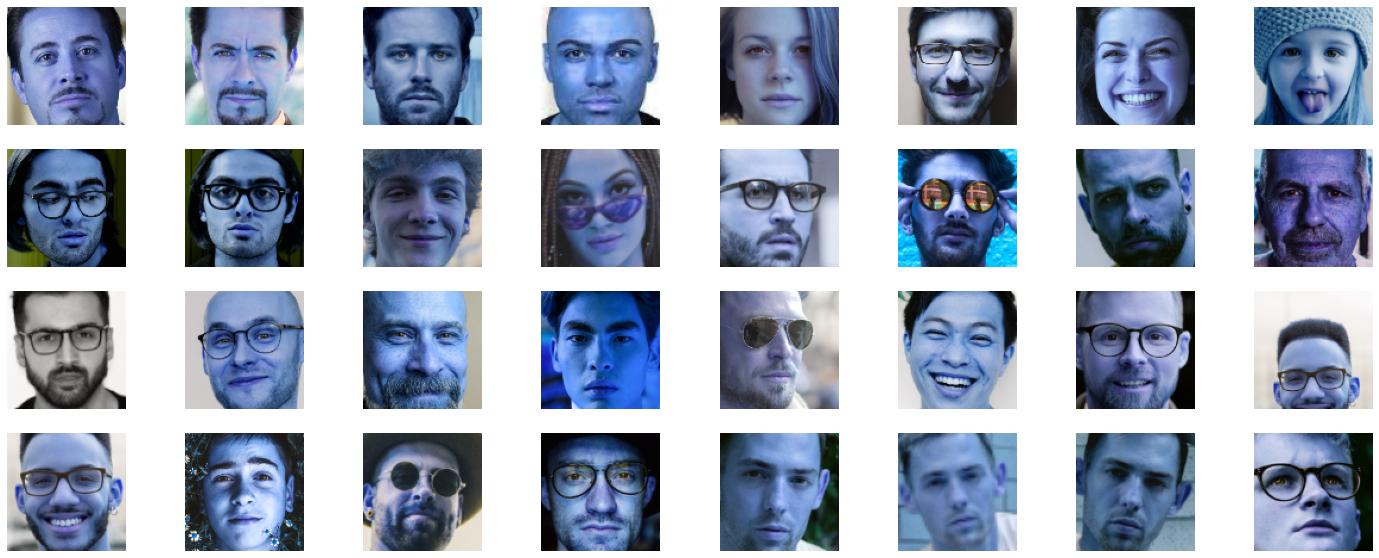

In [ ]:
fig, ax = plt.subplots(4, 8, figsize=(25, 10))

for i, face in enumerate(X_false[:32]):
  plt.subplot(4, 8, i+1)
  plt.imshow(face, cmap='gray')
  plt.axis("off")

In [ ]:
X = np.concatenate((X_true, X_false))
f = np.zeros((1, len(X_false)))
t = np.ones((1, len(X_true)))
y = np.concatenate((*t, *f))

In [ ]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (134, 100, 100)
y shape:  (134,)


In [ ]:
X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
print("X shape:", X.shape)

X shape: (134, 10000)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train shape:",X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (93, 10000)
y_train shape: (93,)


Для того, щоб методи класифікації працювали швидше та краще використаємо PCA

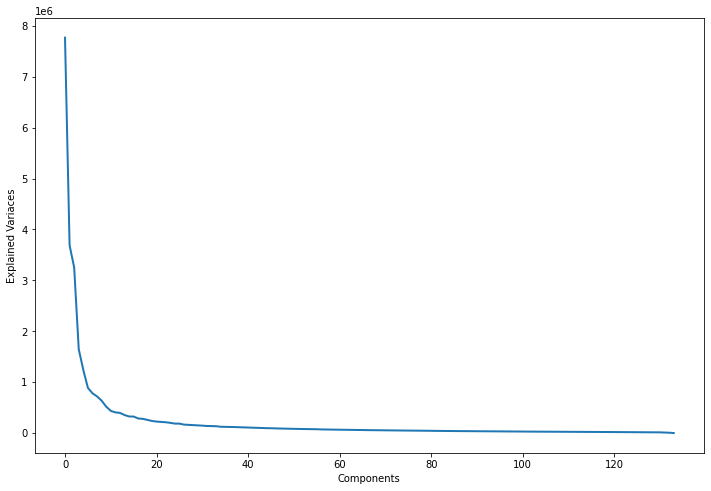

In [ ]:
pca=PCA()
pca.fit(X)
plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [ ]:
pca=PCA(n_components=40, whiten=True)
pca.fit(X_train)

PCA(n_components=40, whiten=True)

Text(0.5, 1.0, 'Average Face')

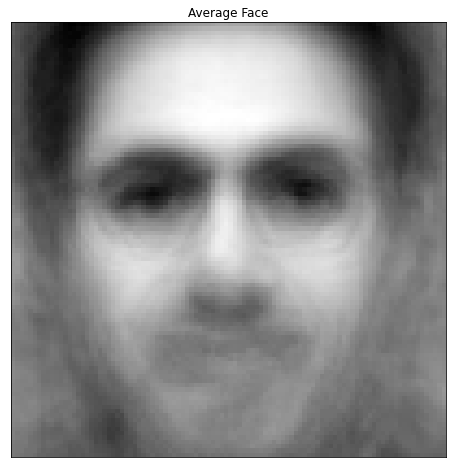

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((100,100)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

In [ ]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train_pca, y_train)
y_pred=rfc.predict(X_test_pca)
print("Accuracy score: {:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision score: {:0.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:0.2f}".format(metrics.recall_score(y_test, y_pred)))

Accuracy score: 0.73
Precision score: 0.86
Recall score: 0.69


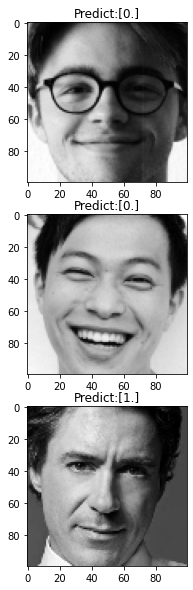

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

indexes = np.random.randint(len(y_test), size=3)
for l, i in enumerate(indexes):
  y_pred = rfc.predict(X_test_pca[i].reshape(1,-1))

  ax[l].imshow(X_test[i].reshape(100, 100), cmap='gray')
  ax[l].set(title = f'Predict:{y_pred}')

### MLPClassifier

In [ ]:
mlpc = MLPClassifier()
mlpc.fit(X_train_pca, y_train)
y_pred=mlpc.predict(X_test_pca)
print("Accuracy score: {:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision score: {:0.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:0.2f}".format(metrics.recall_score(y_test, y_pred)))

Accuracy score: 0.85
Precision score: 0.83
Recall score: 0.96


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


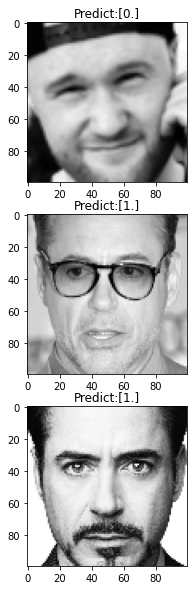

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

indexes = np.random.randint(len(y_test), size=3)
for l, i in enumerate(indexes):
  y_pred = mlpc.predict(X_test_pca[i].reshape(1,-1))

  ax[l].imshow(X_test[i].reshape(100, 100), cmap='gray')
  ax[l].set(title = f'Predict:{y_pred}')

### SVC

In [ ]:
svc = SVC()
svc.fit(X_train_pca, y_train)
y_pred=svc.predict(X_test_pca)
print("Accuracy score: {:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision score: {:0.2f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall score: {:0.2f}".format(metrics.recall_score(y_test, y_pred)))

Accuracy score: 0.78
Precision score: 0.77
Recall score: 0.92


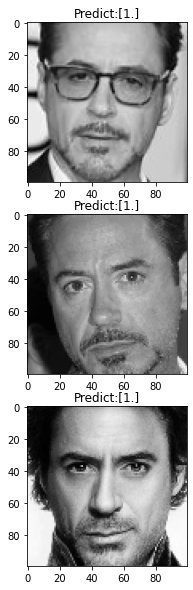

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

indexes = np.random.randint(len(y_test), size=3)
for l, i in enumerate(indexes):
  y_pred = svc.predict(X_test_pca[i].reshape(1,-1))

  ax[l].imshow(X_test[i].reshape(100, 100), cmap='gray')
  ax[l].set(title = f'Predict:{y_pred}')

Відповідно до наведених вище результатів MLPClassifier має найкращі результати. Особливістю моделі MLPClassifier є використання багатошарового перецептрону. Саме це дає перевагу MLPClassifier над іншими, тому що таким чином алгоритм знаходить закономірності, які не здатні помітити інші методи.